<a href="https://colab.research.google.com/github/cwenger91/LiDAR_Classification_DL/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIDAR Packet Info

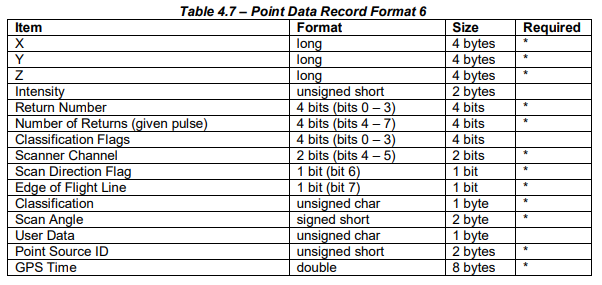

LIDAR Info
Classification values:


*   0: Created
*   1: Unclassified
*   2: Ground
*   3: Low Vegetation
*   4:  Medium Vegetation
*   5 High Vegetation
*   6 Building
*   7 Low Point (“low noise”)
*   8 High Point (typically “high noise”). Note that this 
*   9 Water
*   10 Rail
*   11 Road Surface
*   12 Bridge Deck
*   13 Wire - Guard
*   14 Wire – Conductor (Phase)
*   15 Transmission Tower
*   16 WIre-structure Connector (e.g. Insulator)
*   17 Reserved
*   18-63 Reserved



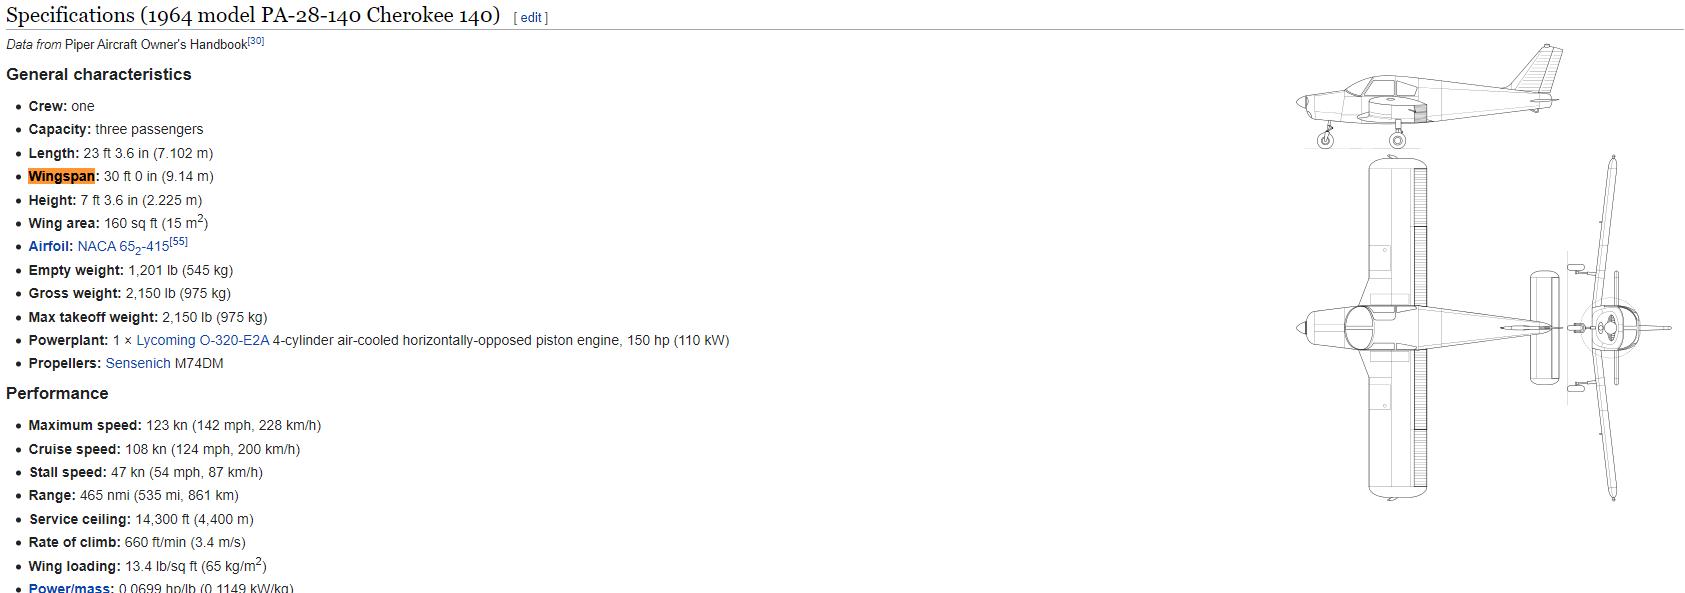

In [1]:
#Define the emergency landing area for the PA-28-140
EL_LENGTH = 200 # ft
EL_WIDTH = 40 #ft
LIDAR_SIZE = (2000,2000) #specified as 2000 ft by 2000 ft tiling scheme
NUM_LAS_POINTS = 2048 # Maximum number of points based on the smallest LIDAR file size
NUM_POINTS = 2048# This constant was calculated by using EL_LENGTH/ LIDAR_SIZE[0]/# points
BATCH_SIZE = 32
DEBUG = 1  #Debug flag for development
%load_ext tensorboard

In [2]:
## INSTALL Manual python-site packages
!pip install laspy
# !pip install open3d # Not Used yet
## IMPORT python-site packages
import urllib.request
from zipfile import ZipFile
import os
import glob
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from laspy.file import File
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import datetime
# import open3d as o3d #Not Used yet
from google.colab import drive
#Mount google drive that contains smaller dataset of the LIDAR Files over Peroria

     |████████████████████████████████| 491kB 4.0MB/s 



*   -Peroria_LIDAR_Files
*    --train
*      ---20 .las files
*    --test
*    ---20 .las files

In [4]:
if not DEBUG:
  drive.mount('/content/drive')

In [5]:
if DEBUG:
  urllib.request.urlretrieve("https://github.com/cwenger91/LiDAR_Classification_DL/raw/main/sampledata/sampledata.zip","sampledata.zip")
else:
  LidarDataSet = '/content/drive/MyDrive/classified_files.zip'

In [6]:
## Returns the scaled [x,y,z] points
## Based on the data taken by Illinois Department of Transportation District 4, Peoria County
# INPUT:
# 1) LASer format file <filename>.las
# OUTPUT:
# 1) Ranks 4 Tensor [x-coordinate,y-coordinate,z-coordinate,Classification]
def get_points(lasfile):
  points_tf = tf.constant([lasfile.x[0:NUM_LAS_POINTS],lasfile.y[0:NUM_LAS_POINTS],lasfile.z[0:NUM_LAS_POINTS],lasfile.Classification[0:NUM_LAS_POINTS]],dtype=tf.float64,shape=(4,NUM_LAS_POINTS))
  #ymap_tf = tf.constant(lasfile.y[I],dtype=float,shape=(len(lasfile.y[I])))
  #zmap_tf = tf.constant(lasfile.z[I],dtype=float,shape=(len(lasfile.z[I])))
  return points_tf

In [7]:
# Split the LAS Point Cloud packets into two tensors to be loaded into the dataset
# This removes extra noise that is stored in the point Cloud for LAS files
# INPUTS:
#   1) Ranks 4 Tensor [x-coordinate,y-coordinate,z-coordinate,Classification]
# OUTPUTS: 
#   1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
#   2) Ranks 1 Tensor [Classification]
def split_image_label(points_tf):
  return tf.constant(points_tf[0:3,:]), tf.constant(points_tf[3,:])

In [8]:
# Create Train and Test Dataset from LASer files
# PROCESS:
# 1) Capture point data from LASer files in train and test folder
# 2) Sample small set of points around a unique_x value
# 3) Append Data to train/test point and labels
# INPUTS: 
# NONE
# OUTPUTS:
#   1) Train points dataset Rank 3 Tensor length is NUM_LAS_POINTS
#   2) Train labels dataset Rank 1 Tensor length is NUM_LAS_POINTS
#   3) Test points dataset Rank 3 Tensor length is NUM_LAS_POINTS
#   4) Test labels dataset Rank 1 Tensor length is NUM_LAS_POINTS
def parse_dataset():
  train_points = []
  train_labels = []
  test_points = []
  test_labels = []
  class_map = {}
  if DEBUG:
    folders = glob.glob("/content/sampledata/*")
  else:
    folders = glob.glob("/content/classified_files/*")
  for i, folder in enumerate(folders):
    print("processing class: {}".format(os.path.basename(folder)))
    class_map[i] = folder.split("/")[-1]
    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files = glob.glob(os.path.join(folder, "test/*"))
    

  # Sample points from each LIDAR file in the train folder
    for f in train_files:
      lasfileTrain = File(f, mode='r')
      points_tf,label = split_image_label(get_points(lasfileTrain))
      points_tf = tf.transpose(points_tf)
      train_points.append(points_tf)
      train_labels.append(i)

    # Sample points from each LIDAR file in the test folder
    for f in test_files:
      lasfileTest = File(f, mode='r')
      points_tf,label = split_image_label(get_points(lasfileTest))
      points_tf = tf.transpose(points_tf)
      test_points.append(points_tf)
      test_labels.append(i)
  return train_points, train_labels, test_points, test_labels,class_map

In [9]:
def augment(points, label):
  # jitter points
  points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
  # shuffle points
  points = tf.random.shuffle(points)
  return points, label

def conv_bn(x,filters):
  x = tf.keras.layers.Conv1D(filters,kernel_size=1,padding="valid")(x)
  x = tf.keras.layers.BatchNormalization(momentum=0.0)(x)
  return tf.keras.layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = tf.keras.layers.Dense(filters)(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.0)(x)
    return tf.keras.layers.Activation("relu")(x)

In [10]:

if not DEBUG:
  with ZipFile(LidarDataSet, 'r') as zip:
          zip.extractall()
else:
  with ZipFile('sampledata.zip','r') as zip:
          zip.extractall()

In [11]:
train_points, train_labels, test_points, test_labels, CLASS_MAP = parse_dataset()

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

processing class: rural


In [12]:
#cite @David Griffiths
#https://keras.io/examples/vision/pointnet/
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [13]:
#cite @David Griffiths
#https://keras.io/examples/vision/pointnet/
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = tf.keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = tf.keras.layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [14]:
NUM_LABELS = 9
inputs = tf.keras.Input(shape=(NUM_LAS_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = tf.keras.layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_LABELS, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [15]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train_dataset, epochs=20, validation_data=test_dataset,callbacks=[tensorboard_callback])

Epoch 1/20
1/1 [==============================] - 36s 36s/step - loss: 2.1972 - sparse_categorical_accuracy: 1.0000 - val_loss: 999614.7500 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 633ms/step - loss: 2.1954 - sparse_categorical_accuracy: 1.0000 - val_loss: 1001608.6250 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 63ms/step - loss: 2.1937 - sparse_categorical_accuracy: 1.0000 - val_loss: 1000345.2500 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 73ms/step - loss: 2.1919 - sparse_categorical_accuracy: 1.0000 - val_loss: 995594.6875 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 70ms/step - loss: 2.1901 - sparse_categorical_accuracy: 1.0000 - val_loss: 996890.2500 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 67ms/step - lo

In [ ]:
%tensorboard --logdir logs/fit

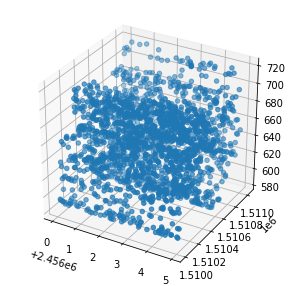

In [33]:
#cite @David Griffiths
#https://keras.io/examples/vision/pointnet/
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()
if DEBUG:
  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(111, projection="3d")
  ax.scatter(points[0,:, 0], points[0,:, 1], points[0,:, 2])
  ax.set_axis_off 
else:
  # plot points with predicted class and label
  fig = plt.figure(figsize=(15, 10))
  for i in range(8):
      ax = fig.add_subplot(2, 4, i + 1, projection="3d")
      ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
      ax.set_title(
          "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
          )
      )
      ax.set_axis_off()
  plt.show()